In [1]:
import os
# Set environment variables
os.environ['TOKENIZERS_PARALLELISM'] = 'false'  # Prevents a warning from the tokenizer
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specifies which GPU to use, '0' means first GPU
os.environ["WORLD_SIZE"] = "1"
import pathlib
import pandas as pd
import numpy as np
import torch
from transformers import DebertaV2Tokenizer, DebertaV2Model
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score


# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Read CSV and remove duplicates
print('Reading data')
basedir = pathlib.Path.cwd().parent
file_path = basedir / 'data' / 'raw' / 'annotated_brexit_tweets.csv'
df = pd.read_csv(file_path)
df.drop_duplicates(inplace=True)
df = df[~df.tweet_text.isna()]

# Step 2: Extract Embeddings using Deberta
print('Importing Embedding Model')
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v2-xlarge')
model = DebertaV2Model.from_pretrained('microsoft/deberta-v2-xlarge').to(device)

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().squeeze().numpy()

print('Extracting embeddings')
embeddings = df['tweet_text'].apply(get_embeddings)
embeddings = np.vstack(embeddings.values)

# Step 3: Compress Embeddings using PCA
print('Compressing embeddings using PCA')
pca = PCA(n_components=0.95)
embeddings_pca = pca.fit_transform(embeddings)

# Step 4: Prepare the target variable
y = df['Stance'].apply(lambda x: 1 if x == 'REMAIN' else 0).values

# Step 5: Train Logistic Regression Model and Evaluate using Multiple Metrics
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
roc_auc_scores = []
macro_f1_scores = []
micro_f1_scores = []

for train_index, test_index in kf.split(embeddings_pca):
    X_train, X_test = embeddings_pca[train_index], embeddings_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    y_pred = lr_model.predict(X_test)
    y_proba = lr_model.predict_proba(X_test)[:, 1]
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    macro_f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    micro_f1_scores.append(f1_score(y_test, y_pred, average='micro'))

# Calculate mean and standard deviation for each metric
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
roc_auc_mean, roc_auc_std = np.mean(roc_auc_scores), np.std(roc_auc_scores)
macro_f1_mean, macro_f1_std = np.mean(macro_f1_scores), np.std(macro_f1_scores)
micro_f1_mean, micro_f1_std = np.mean(micro_f1_scores), np.std(micro_f1_scores)

# Output the results
print(f'Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}')
print(f'ROC-AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}')
print(f'Macro F1: {macro_f1_mean:.4f} ± {macro_f1_std:.4f}')
# print(f'Micro F1: {micro_f1_mean:.4f} ± {micro_f1_std:.4f}')



Reading data
Importing Embedding Model
Extracting embeddings
Compressing embeddings using PCA
Accuracy: 0.8449 ± 0.0253
ROC-AUC: 0.9221 ± 0.0086
Macro F1: 0.8417 ± 0.0242


#### Estimating the inference times

In [2]:
import time


In [3]:
# Step 5: Train Logistic Regression Model on the whole dataset
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(embeddings_pca, y)

# Step 6: Sample 100 texts from the dataset for inference time estimation
sample_texts = df['tweet_text'].sample(100, random_state=42)

# Measure inference time for each sampled text
inference_times = []
for text in sample_texts:
    start_time = time.time()
    
    # Step 2: Project text using the Text Embedder
    embedding = get_embeddings(text).reshape(1, -1)
    
    # Step 3: Compress embedding using trained PCA
    embedding_pca = pca.transform(embedding)
    
    # Step 4: Compute probability score using trained logistic regression
    prob_score = lr_model.predict_proba(embedding_pca)[:, 1]
    
    end_time = time.time()
    inference_times.append(end_time - start_time)

# Calculate the average time and standard deviation
average_time = np.mean(inference_times)
std_time = np.std(inference_times)

# Output the results
print(f'Average inference time: {average_time:.4f} seconds')
print(f'Standard deviation of inference time: {std_time:.4f} seconds')


Average inference time: 0.0602 seconds
Standard deviation of inference time: 0.0126 seconds


---
Trying to calibrate the binary classifier

In [4]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


In [5]:
lr_model = LogisticRegression(max_iter=1000)
calibrated_clf = CalibratedClassifierCV(lr_model, method='isotonic', cv=5)

# Step 5: Train Logistic Regression Model and Evaluate using Multiple Metrics
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
roc_auc_scores = []
macro_f1_scores = []
micro_f1_scores = []

for train_index, test_index in kf.split(embeddings_pca):
    X_train, X_test = embeddings_pca[train_index], embeddings_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr_model = LogisticRegression(max_iter=1000)
    calibrated_clf = CalibratedClassifierCV(lr_model, method='isotonic', cv=5)
    calibrated_clf.fit(X_train, y_train)
    
    y_pred = calibrated_clf.predict(X_test)
    y_proba = calibrated_clf.predict_proba(X_test)[:, 1]
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    macro_f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    micro_f1_scores.append(f1_score(y_test, y_pred, average='micro'))

# Calculate mean and standard deviation for each metric
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
roc_auc_mean, roc_auc_std = np.mean(roc_auc_scores), np.std(roc_auc_scores)
macro_f1_mean, macro_f1_std = np.mean(macro_f1_scores), np.std(macro_f1_scores)
micro_f1_mean, micro_f1_std = np.mean(micro_f1_scores), np.std(micro_f1_scores)

# Output the results
print(f'Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}')
print(f'ROC-AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}')
print(f'Macro F1: {macro_f1_mean:.4f} ± {macro_f1_std:.4f}')


Accuracy: 0.8435 ± 0.0353
ROC-AUC: 0.9268 ± 0.0077
Macro F1: 0.8393 ± 0.0349


#### Evaluate calibration

In [6]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt


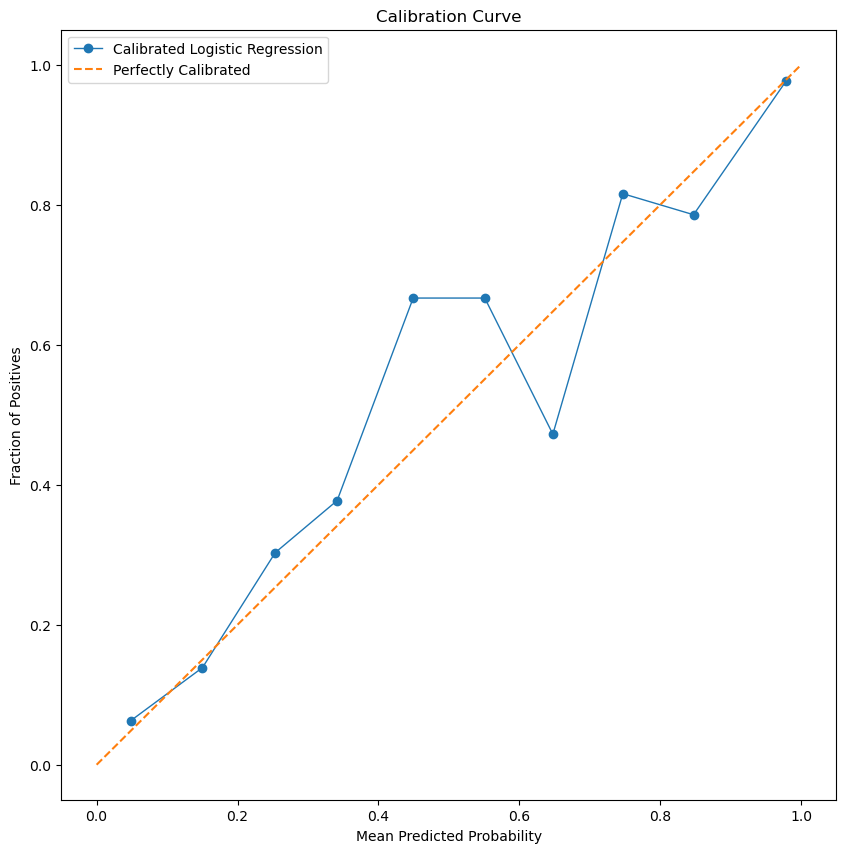

In [7]:
lr_model = LogisticRegression(max_iter=1000)
calibrated_clf = CalibratedClassifierCV(lr_model, method='isotonic', cv=5)

# Perform cross-validation and get predictions
y_pred = cross_val_predict(calibrated_clf, embeddings_pca, y, cv=5, method='predict')
y_proba = cross_val_predict(calibrated_clf, embeddings_pca, y, cv=5, method='predict_proba')[:, 1]

# Plot calibration curve
prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)

plt.figure(figsize=(10, 10))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibrated Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()



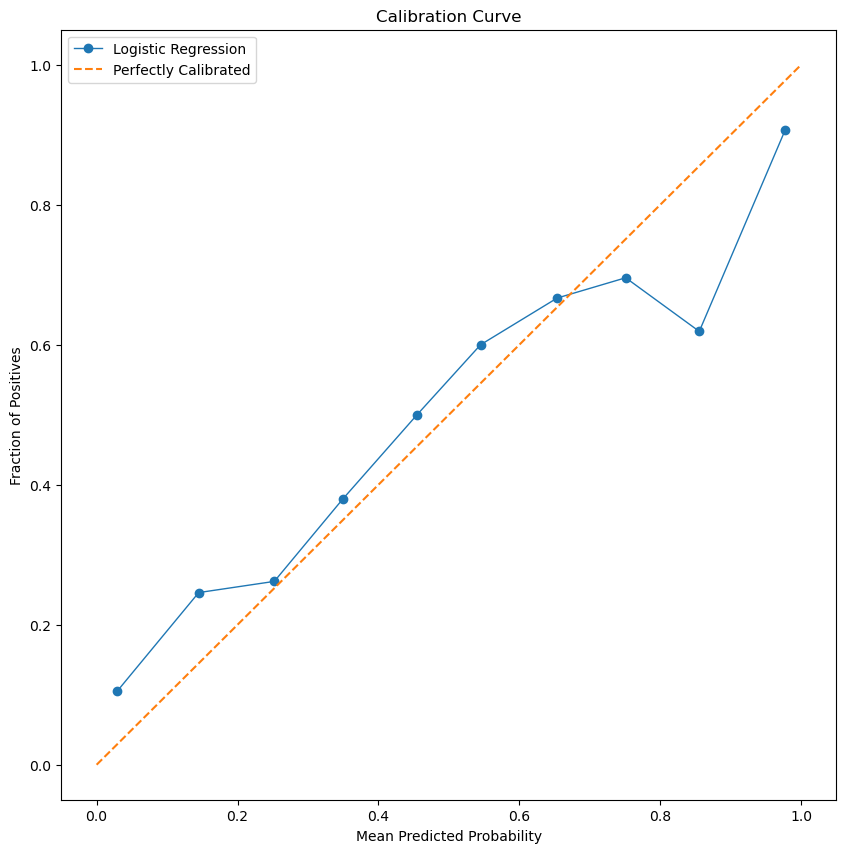

In [8]:
lr_model = LogisticRegression(max_iter=1000)

# Perform cross-validation and get predictions
y_pred = cross_val_predict(lr_model, embeddings_pca, y, cv=5, method='predict')
y_proba = cross_val_predict(lr_model, embeddings_pca, y, cv=5, method='predict_proba')[:, 1]

# Plot calibration curve
prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)

plt.figure(figsize=(10, 10))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()


#### Save the binary classifier and the PCA projector

In [11]:
import joblib
from sklearn.calibration import CalibratedClassifierCV


In [12]:
# Step 3: Compress Embeddings using PCA
print('Compressing embeddings using PCA')
pca = PCA(n_components=0.95)
embeddings_pca = pca.fit_transform(embeddings)

# Step 4: Prepare the target variable
y = df['Stance'].apply(lambda x: 1 if x == 'REMAIN' else 0).values

lr_model = LogisticRegression(max_iter=1000)
calibrated_clf = CalibratedClassifierCV(lr_model, method='isotonic', cv=5)
calibrated_clf.fit(embeddings_pca, y)

# Save the trained classifier and PCA projector
joblib.dump(calibrated_clf, basedir / 'data' / 'processed' / f'calibrated_classifier_{'DEBERTA'}_{'95perc'}.pkl')
joblib.dump(pca, basedir / 'data' / 'processed' / f'pca_projector_{'DEBERTA'}_{'95perc'}.pkl')


Compressing embeddings using PCA


['/mnt/nas/minici/SocialAIGym/data/processed/pca_projector_DEBERTA_95perc.pkl']